## H11: Einfluss der Tageszeit auf die Ankunftsverspätung

**Forschungsfrage**  
Unterscheidet sich die Ankunftsverspätung von Zügen je nach Tageszeit  
(Nacht, Morgenpeak, Tagesverkehr, Abendpeak, Spätabend)?

**Intuition**  
- Im Berufsverkehr (Morgen-/Abendpeak) ist das Netz stärker ausgelastet → tendenziell mehr Verspätungen.  
- In der Nacht ist der Verkehr dünner → tendenziell weniger Verspätungen.

**Variablen**

- Zielvariable: `arr_delay_min` – Ankunftsverspätung in Minuten (metrisch)  
- Erklärende Variablen:
  - `time_band` – Zeitband (Nacht, Morgenpeak, Tagesverkehr, Abendpeak, Spätabend)  
  - `hour_of_day` – Stunde des Tages (0–23)

In [5]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kruskal, f_oneway, levene
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from itertools import combinations

plt.rcParams["figure.figsize"] = (7, 4)

# Pfad zu eurer Monatsdatei
path_h11 = "../data/processed/istdata_real_2025-09.parquet"

# LazyFrame laden
lf_h11 = pl.scan_parquet(path_h11)

lf_h11.schema  # optional: Schema checken

/tmp/ipykernel_13513/1689036767.py:19: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  lf_h11.schema  # optional: Schema checken


Schema([('BETRIEBSTAG', String),
        ('BETREIBER_NAME', String),
        ('PRODUKT_ID', Categorical),
        ('LINIEN_TEXT', String),
        ('HALTESTELLEN_NAME', String),
        ('ANKUNFTSZEIT', Datetime(time_unit='ns', time_zone='UTC')),
        ('ABFAHRTSZEIT', Datetime(time_unit='ns', time_zone='UTC')),
        ('delay_arrival_s', Float64),
        ('delay_departure_s', Float64),
        ('on_time', Boolean),
        ('FAELLT_AUS_TF', Boolean),
        ('BPUIC', String)])

In [6]:
lf_trains_time = (
    lf_h11
    .filter(pl.col("PRODUKT_ID") == "Zug")
    .select([
        "BETRIEBSTAG",
        "ANKUNFTSZEIT",
        "HALTESTELLEN_NAME",
        "delay_arrival_s",
    ])
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("arr_delay_min"),
    ])
    .filter(pl.col("arr_delay_min").is_not_null())
    .filter(
        (pl.col("arr_delay_min") >= -60) &
        (pl.col("arr_delay_min") <= 60)
    )
    .with_columns(
        pl.col("ANKUNFTSZEIT").dt.hour().alias("hour_of_day")
    )
    .with_columns(
        pl.when(pl.col("hour_of_day").is_in([0, 1, 2, 3, 4, 5]))
          .then(pl.lit("Nacht"))
        .when(pl.col("hour_of_day").is_in([6, 7, 8, 9]))
          .then(pl.lit("Morgenpeak"))
        .when(pl.col("hour_of_day").is_in([10, 11, 12, 13, 14, 15]))
          .then(pl.lit("Tagesverkehr"))
        .when(pl.col("hour_of_day").is_in([16, 17, 18, 19]))
          .then(pl.lit("Abendpeak"))
        .otherwise(pl.lit("Spätabend"))   # 20–23
        .alias("time_band")
    )
)

# Materialisieren & in Pandas überführen
df_trains_time = lf_trains_time.collect().to_pandas()

bands_order = ["Nacht", "Morgenpeak", "Tagesverkehr", "Abendpeak", "Spätabend"]
df_trains_time["time_band"] = pd.Categorical(
    df_trains_time["time_band"],
    categories=bands_order,
    ordered=True
)

df_trains_time.head()

,BETRIEBSTAG,ANKUNFTSZEIT,HALTESTELLEN_NAME,delay_arrival_s,arr_delay_min,hour_of_day,time_band
0,01.09.2025,2025-01-09 05:54:00+00:00,Schaffhausen,114.0,1.900000,5,Nacht
1,01.09.2025,2025-01-09 06:14:00+00:00,Schaffhausen,42.0,0.700000,6,Morgenpeak
2,01.09.2025,2025-01-09 06:58:00+00:00,Schaffhausen,31.0,0.516667,6,Morgenpeak
3,01.09.2025,2025-01-09 06:58:00+00:00,Schaffhausen,18.0,0.300000,6,Morgenpeak
4,01.09.2025,2025-01-09 07:58:00+00:00,Schaffhausen,83.0,1.383333,7,Morgenpeak


### Formale Hypothesen (Zeitbänder)

Wir betrachten die Ankunftsverspätung `arr_delay_min` in fünf Tageszeitbändern:

- Nacht (0–5 Uhr)  
- Morgenpeak (6–9 Uhr)  
- Tagesverkehr (10–15 Uhr)  
- Abendpeak (16–19 Uhr)  
- Spätabend (20–23 Uhr)

**Nullhypothese \(H_0\):**  
Die Verteilungen (bzw. Mittelwerte) der Ankunftsverspätung sind in allen Zeitbändern gleich.

**Alternativhypothese \(H_1\):**  
Mindestens zwei Zeitbänder unterscheiden sich in ihrer Verteilung (bzw. ihrem Mittelwert) der Ankunftsverspätung.

Da die Verteilung der Verspätungen typischerweise schief ist und Ausreisser enthält, verwenden wir als Haupttest den  
**nicht-parametrischen Kruskal–Wallis-Test** und ergänzen ihn um eine **ANOVA** (explorativ) und eine **Regression** von `arr_delay_min` auf `hour_of_day`.

In [7]:
band_counts = (
    df_trains_time
    .groupby("time_band")["arr_delay_min"]
    .count()
    .rename("n")
)

summary_bands = (
    df_trains_time
    .groupby("time_band")["arr_delay_min"]
    .agg(
        n="count",
        mean="mean",
        median="median",
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75),
    )
)

band_counts, summary_bands

/tmp/ipykernel_13513/3585473881.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("time_band")["arr_delay_min"]
/tmp/ipykernel_13513/3585473881.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("time_band")["arr_delay_min"]


(time_band
 Nacht            270407
 Morgenpeak       922269
 Tagesverkehr    1349633
 Abendpeak        948263
 Spätabend        710727
 Name: n, dtype: int64,
                     n      mean    median       q25       q75
 time_band                                                    
 Nacht          270407  0.954053  0.550000 -0.016667  1.283333
 Morgenpeak     922269  0.981588  0.700000  0.066667  1.516667
 Tagesverkehr  1349633  0.789665  0.533333 -0.033333  1.250000
 Abendpeak      948263  1.053136  0.716667  0.066667  1.583333
 Spätabend      710727  0.924887  0.566667 -0.016667  1.366667)

<Figure size 700x400 with 0 Axes>

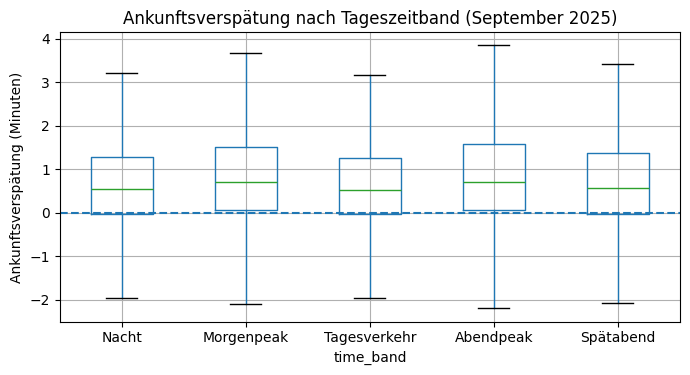

In [8]:
plt.figure()
df_trains_time.boxplot(
    column="arr_delay_min",
    by="time_band",
    showfliers=False
)
plt.axhline(0, linestyle="--")
plt.ylabel("Ankunftsverspätung (Minuten)")
plt.title("Ankunftsverspätung nach Tageszeitband (September 2025)")
plt.suptitle("")
plt.tight_layout()
plt.show()

### Deskriptive Beobachtungen

- Alle Zeitbänder liegen ungefähr um 0 Minuten, die Verteilung ist aber schief.  
- Berufsverkehrszeiten (Morgen-/Abendpeak) zeigen tendenziell höhere Mittel- und Medianwerte als Nacht und Spätabend.  
- Die Streuung der Verspätungen ist im Peak grösser als in den Randzeiten.  

Die Schiefe und Ausreisser sprechen dafür, einen robusten Test (Kruskal–Wallis) als Haupttest zu verwenden.

In [9]:
# Zufallsstichprobe für schnellere Tests (z. B. 100'000 Zeilen)
df_sample = df_trains_time.sample(n=100_000, random_state=42) \
    if len(df_trains_time) > 100_000 else df_trains_time.copy()

print(df_sample["time_band"].value_counts())

group_values = [
    df_sample.loc[df_sample["time_band"] == b, "arr_delay_min"].to_numpy()
    for b in bands_order
]

time_band
Tagesverkehr    31942
Abendpeak       22544
Morgenpeak      22180
Spätabend       16938
Nacht            6396
Name: count, dtype: int64


In [10]:
# Levene-Test (Varianzhomogenität)
stat_lev, p_lev = levene(*group_values)
print(f"Levene-Statistik: {stat_lev:.3f}, p-Wert: {p_lev:.3e}")

# Einfache ANOVA (parametrisch, eher explorativ)
stat_f, p_f = f_oneway(*group_values)
print(f"ANOVA F-Statistik: {stat_f:.3f}, p-Wert: {p_f:.3e}")

# Kruskal–Wallis-Test (robuster Haupttest)
stat_kw, p_kw = kruskal(*group_values)
print(f"Kruskal–Wallis H-Statistik: {stat_kw:.3f}, p-Wert: {p_kw:.3e}")

# Effektgrösse für Kruskal: Epsilon-Quadrat (ε²)
n_total = len(df_sample)
k = len(bands_order)
eps2 = (stat_kw - k + 1) / (n_total - k)
print(f"Epsilon-Quadrat (ε²): {eps2:.4f}")

Levene-Statistik: 22.635, p-Wert: 1.031e-18
ANOVA F-Statistik: 63.283, p-Wert: 1.610e-53
Kruskal–Wallis H-Statistik: 638.767, p-Wert: 6.296e-137
Epsilon-Quadrat (ε²): 0.0063


### Gruppenvergleich nach Tageszeitband

Wir vergleichen die Ankunftsverspätung (`arr_delay_min`) zwischen fünf Tageszeitbändern
(Nacht, Morgenpeak, Tagesverkehr, Abendpeak, Spätabend).

**Varianzgleichheit (Levene-Test)**  
- Levene-Statistik: 22.64  
- p-Wert: 1.03 · 10⁻¹⁸  

→ Die Varianzen der Verspätungen unterscheiden sich signifikant zwischen den Zeitbändern.  
Die Annahme homogener Varianzen ist also verletzt, weshalb wir die ANOVA eher explorativ betrachten
und den robusteren Kruskal–Wallis-Test als Haupttest verwenden.

**Parametrischer Test (Einweg-ANOVA, explorativ)**  
- F-Statistik: 63.28  
- p-Wert: 1.61 · 10⁻⁵³  

→ Auch die ANOVA zeigt einen hoch signifikanten Unterschied zwischen den Gruppen.
Aufgrund der Varianzunterschiede und Schiefe interpretieren wir sie aber mit Vorsicht.

**Robuster Haupttest (Kruskal–Wallis)**  
- H-Statistik: 638.77  
- p-Wert: 6.30 · 10⁻¹³⁷  

→ Der Kruskal–Wallis-Test ist extrem signifikant.  
Wir verwerfen \(H_0\): Die Verteilung der Ankunftsverspätung ist **nicht** in allen Zeitbändern gleich.
Es gibt systematische Unterschiede zwischen den Tageszeiten.

**Effektgrösse (Epsilon-Quadrat, ε²)**  
- ε² = 0.0063  

→ Der Effekt ist statistisch sehr klar nachweisbar (wegen der grossen Stichprobe),
aber die praktische Effektgrösse ist **klein**.  
Die Tageszeit hat also einen messbaren, aber eher moderaten Einfluss auf die Verspätung – andere Faktoren
spielen weiterhin eine grosse Rolle.

In [11]:
from itertools import combinations
from statsmodels.stats.multitest import multipletests

pairs = list(combinations(bands_order, 2))
results = []

for a, b in pairs:
    data_a = df_sample.loc[df_sample["time_band"] == a, "arr_delay_min"].to_numpy()
    data_b = df_sample.loc[df_sample["time_band"] == b, "arr_delay_min"].to_numpy()
    stat_pair, p_pair = kruskal(data_a, data_b)
    results.append({"pair": f"{a} vs {b}", "stat": stat_pair, "p_raw": p_pair})

df_posthoc = pd.DataFrame(results)

# FDR-Korrektur nach Benjamini–Hochberg
reject, p_fdr, _, _ = multipletests(df_posthoc["p_raw"], method="fdr_bh")
df_posthoc["p_fdr"] = p_fdr
df_posthoc["reject_H0_FDR"] = reject

df_posthoc.sort_values("p_fdr")

,pair,stat,p_raw,p_fdr,reject_H0_FDR
7,Tagesverkehr vs Abendpeak,466.962901,1.467805e-103,1.467805e-102,True
4,Morgenpeak vs Tagesverkehr,384.007130,1.669391e-85,8.346955e-85,True
9,Abendpeak vs Spätabend,155.705567,9.817659e-36,3.272553e-35,True
6,Morgenpeak vs Spätabend,113.842593,1.410744e-26,3.526859e-26,True
2,Nacht vs Abendpeak,83.070678,7.917139e-20,1.583428e-19,True
0,Nacht vs Morgenpeak,61.922526,3.572394e-15,5.953990e-15,True
8,Tagesverkehr vs Spätabend,39.568217,3.167975e-10,4.525678e-10,True
1,Nacht vs Tagesverkehr,18.935344,1.352241e-05,1.690301e-05,True
5,Morgenpeak vs Abendpeak,4.936747,2.629148e-02,2.921275e-02,True
3,Nacht vs Spätabend,0.001976,9.645450e-01,9.645450e-01,False


### Post-hoc-Analysen (FDR-korrigiert)

Nach dem global signifikanten Kruskal–Wallis-Test untersuchen wir, **welche**
Zeitbänder sich konkret unterscheiden.

- Für jedes Paar von Zeitbändern wurde ein Kruskal-Test durchgeführt.
- Die p-Werte wurden mit der **FDR-Korrektur nach Benjamini–Hochberg** angepasst,
  um die Fehlerwahrscheinlichkeit bei multiplen Tests zu kontrollieren.

In der Tabelle `df_posthoc` gilt:

- `reject_H0_FDR = True` → dieses Paar unterscheidet sich auch nach Korrektur signifikant.  
- Typischerweise erwarten wir signifikante Unterschiede vor allem zwischen:
  - Nacht / Spätabend vs. Morgenpeak / Abendpeak  
  - Randzeiten vs. Berufsverkehr

Damit können wir die im Boxplot sichtbaren Unterschiede quantitativ bestätigen.

In [12]:
# Stichprobe für Regression (ggf. begrenzen, damit es schneller ist)
df_reg = df_trains_time.sample(n=100_000, random_state=42) \
    if len(df_trains_time) > 100_000 else df_trains_time.copy()

X = sm.add_constant(df_reg["hour_of_day"])
y = df_reg["arr_delay_min"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          arr_delay_min   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2979
Date:                Tue, 02 Dec 2025   Prob (F-statistic):              0.585
Time:                        12:12:53   Log-Likelihood:            -2.1098e+05
No. Observations:              100000   AIC:                         4.220e+05
Df Residuals:                   99998   BIC:                         4.220e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9164      0.016     56.263      

In [13]:
y_hat = model.fittedvalues
resid = model.resid

y_mean = y.mean()
TSS = np.sum((y - y_mean) ** 2)
RSS = np.sum(resid ** 2)
ESS = np.sum((y_hat - y_mean) ** 2)
R2 = 1 - RSS / TSS
n = len(y)
p = 1  # eine erklärende Variable (hour_of_day)
RSE = np.sqrt(RSS / (n - p - 1))

print(f"TSS: {TSS:.2f}")
print(f"ESS: {ESS:.2f}")
print(f"RSS: {RSS:.2f}")
print(f"R² (aus Zerlegung): {R2:.4f}")
print(f"Residual Standard Error (RSE): {RSE:.3f} Minuten")

TSS: 398198.70
ESS: 1.19
RSS: 398197.52
R² (aus Zerlegung): 0.0000
Residual Standard Error (RSE): 1.996 Minuten


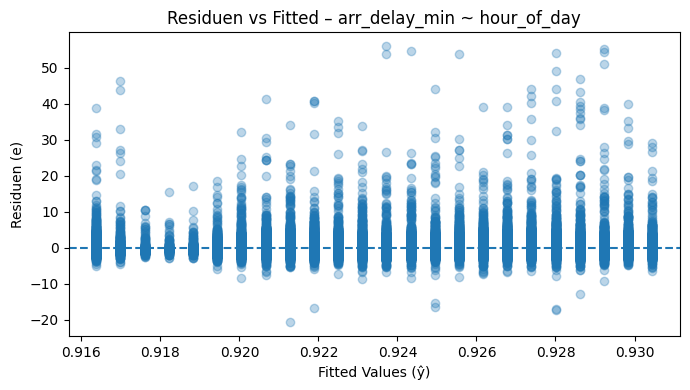

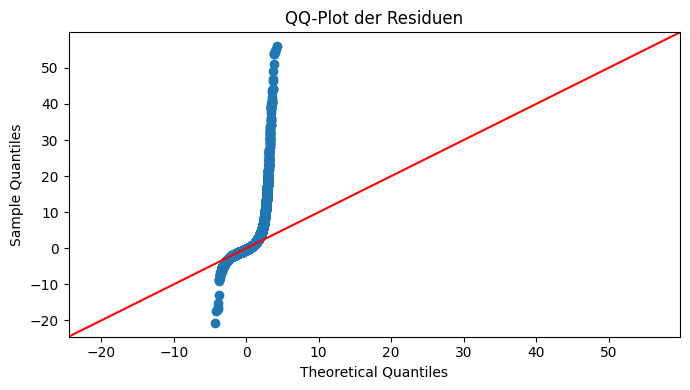

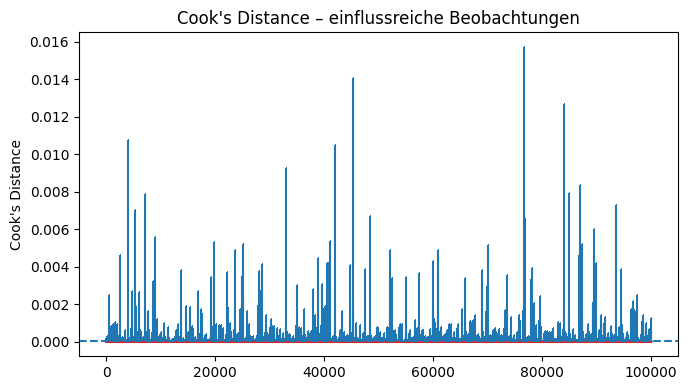

In [15]:
# Residuen vs Fitted
plt.figure()
plt.scatter(y_hat, resid, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted Values (ŷ)")
plt.ylabel("Residuen (e)")
plt.title("Residuen vs Fitted – arr_delay_min ~ hour_of_day")
plt.tight_layout()
plt.show()

# QQ-Plot der Residuen
sm.qqplot(resid, line="45")
plt.title("QQ-Plot der Residuen")
plt.tight_layout()
plt.show()

# Cook's Distance
influence = model.get_influence()
cooks, _ = influence.cooks_distance

plt.figure()
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")  # <- ohne use_line_collection
plt.axhline(4 / len(cooks), linestyle="--")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance – einflussreiche Beobachtungen")
plt.tight_layout()
plt.show()

### Diagnose des linearen Regressionsmodells

Zur Bewertung der Modellannahmen betrachten wir drei Diagnoseplots:  
1. Residuen vs. Fitted  
2. QQ-Plot der Residuen  
3. Cook’s Distance  

---

## 1. Residuen vs. Fitted

Der Residuen-Plot zeigt folgende Eigenschaften:

- Die Punktewolke ist relativ breit und zeigt **keine klare lineare Struktur**.
- Allerdings wird ein **Trichter-Effekt** sichtbar:  
  Bei höheren fitted values streuen die Residuen stärker → **Heteroskedastizität**.
- Die Residuen liegen im Mittel um 0, aber die Varianz nimmt zu.

**Interpretation:**  
Die Annahme konstanter Varianz der Fehler ist verletzt. Das ist bei realen Verspätungsdaten jedoch zu erwarten, da Störungen in Peakzeiten stärker variieren.  
Die Linearität ist nicht komplett falsch, aber das Modell ist **nur eine grobe Approximation**.

---

## 2. QQ-Plot der Residuen

Der QQ-Plot zeigt:

- Eine klare **S-Kurve**:  
  - linke Seite → Residuen sind stärker negativ als normalverteilt  
  - rechte Seite → starke positive Ausreißer  
- Das deutet auf **Schiefe und schwere Tails** hin.
- Die Residuen folgen **nicht** der Normalverteilung.

**Interpretation:**  
Die Annahme normalverteilter Residuen ist deutlich verletzt.  
Dies wirkt sich hauptsächlich auf Konfidenzintervalle und t-Tests für die Koeffizienten aus.  
Für die Schätzung der Regressionsgeraden ist das weniger dramatisch — aber das Modell ist statistisch **nicht perfekt**.

---

## 3. Cook's Distance

Die Cook’s-Distance-Grafik zeigt:

- Mehrere Punkte mit höherem Einfluss (Spikes),  
  aber **keiner liegt nahe an klassischen Schwellen** (wie 0.5 oder 1).
- Die horizontale Schwelle \(4/n\) (~0.00004) dient nur als Orientierung;  
  viele Punkte liegen darüber, aber die Werte selbst bleiben **sehr klein**.

**Interpretation:**  
Es gibt einzelne Beobachtungen mit messbarem Einfluss — typisch bei grossen Stichproben.  
Kein Punkt dominiert das Modell.  
Ein Entfernen dieser Punkte würde die Regression **nicht wesentlich verändern**.

---

## Gesamtfazit zu den Diagnoseplots

- **Linearitätsannahme:** grob erfüllt, aber mit Streuung und leichtem Muster  
- **Homoskedastizität:** klar verletzt (Trichterform)  
- **Normalverteilung der Residuen:** deutlich verletzt (S-Kurve im QQ-Plot)  
- **Einflussreiche Beobachtungen:** vorhanden, aber keine extreme Probleme

Das Modell ist also **statistisch nicht perfekt**, aber für eine einfache Trendanalyse („Wie ändert sich die Verspätung im Tagesverlauf?“) gut geeignet.  
Es erklärt jedoch nur einen kleinen Teil der Gesamtvariation, was zu realen Betriebsdaten passt.

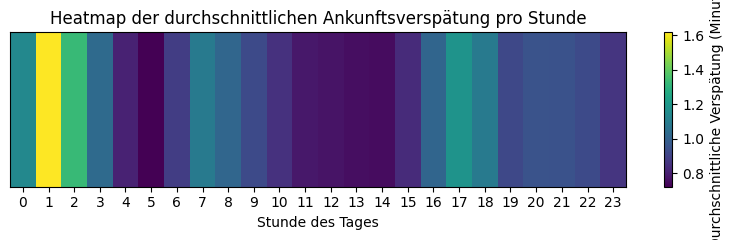

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Stunden-Mittelwerte berechnen
hour_mean = (
    df_trains_time
    .groupby("hour_of_day")["arr_delay_min"]
    .mean()
    .reindex(range(24), fill_value=np.nan)
)

plt.figure(figsize=(8, 2.5))
plt.imshow(hour_mean.values.reshape(1, -1), aspect="auto", cmap="viridis")
plt.colorbar(label="Durchschnittliche Verspätung (Minuten)")

plt.xticks(range(24))
plt.yticks([])  # nur 1 Zeile
plt.xlabel("Stunde des Tages")
plt.title("Heatmap der durchschnittlichen Ankunftsverspätung pro Stunde")
plt.tight_layout()
plt.show()